<div align="center">
  <img src="../../other/logo.png" width="400"/>
</div>


<div style="text-align:center">

</h1>
  <h3 style="color:#888; font-weight:normal; margin-top:0;">A Hands-on Introduction</h3>
</div>


<!-- Welcome message and intro, centered -->
<div style="max-width:700px; margin:auto; font-size:1.2em; text-align:center; line-height:1.6;">

  <strong>Welcome to the <span style="
    font-family:'Segoe UI', 'Arial Rounded MT Bold', 'Arial', sans-serif;
    color:#2685FF; font-weight:800;
    text-shadow:1px 2px 12px #b3d6ff;">P2PFL</span> library!</strong>
  <br><br>
  This notebook provides a step-by-step guide of the library, from the foundational concepts to some more advanced features, preparing you to understand all knowledge required to design your own peer-to-peer federated learning experiments.
</div>

<!-- Index section, centered and neat -->
<div style="max-width:520px; margin:36px auto 0 auto; text-align:center;">
  <div style="
    font-size:2.1em;
    font-weight:800;
    background: linear-gradient(90deg,#339CFF 30%, #84C4FF 100%);
    color: white;
    letter-spacing:2px;
    padding:8px 0 8px 0;
    border-radius:18px;
    box-shadow: 0 2px 18px 0 #b3d6ff77;
    margin-bottom: 16px;
    text-shadow:0 3px 18px #009cff44;
    ">
    🗂️  Index
  </div>
  <ol style="text-align:left; display:inline-block; margin:auto; font-size:1.09em; line-height:1.7;">
    <li><b>Basic concepts</b></li>
    <li><b>Data Loading & partitioning</b></li>
    <li><b>Creating models and nodes</b></li>
    <li><b>Network topologies</b></li>
    <li><b>Starting the learning process</b></li>
    <li><b>Inspecting Local Metrics</b></li>
    <li><b>Configuring your experiments</b></li>
    <li><b>The P2PFL Architecture</b></li>
    <li><b>Conclusions</b></li>
  </ol>
</div>




# ⚙️ Setup 

> **Before diving in, run these cells to set the stage. They handle the boring stuff to ensure your notebook is fully operational before you explore the first section.** 

In [1]:
import logging
import os
import sys
os.environ["DISABLE_RAY"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # quiet TensorFlow
logging.getLogger().setLevel(logging.ERROR)
logging.getLogger("p2pfl").setLevel(logging.ERROR)
logging.getLogger("ray").setLevel(logging.ERROR)

from p2pfl.settings import Settings
Settings.general.DISABLE_RAY = True
Settings.general.LOG_LEVEL   = "INFO"

In [2]:
# --- Plotting and data handling ---
import matplotlib.pyplot as plt
import numpy as np
import time

# --- Core p2pfl components ---
from p2pfl.node import Node
from p2pfl.learning.dataset.p2pfl_dataset import P2PFLDataset
from p2pfl.management.logger import logger

# --- Data Partitioning Strategies ---
from p2pfl.learning.dataset.partition_strategies import (
    RandomIIDPartitionStrategy,
    DirichletPartitionStrategy,
    LabelSkewedPartitionStrategy
)

# --- Model Aggregation Algorithms ---
from p2pfl.learning.aggregators.fedavg import FedAvg
from p2pfl.learning.aggregators.scaffold import Scaffold
from p2pfl.learning.aggregators.fedprox import FedProx
from p2pfl.learning.aggregators.fedmedian import FedMedian
from p2pfl.learning.aggregators.krum import Krum

# --- Communication and Topology ---
from p2pfl.communication.protocols.protobuff.memory import MemoryCommunicationProtocol
from p2pfl.utils.topologies import TopologyFactory, TopologyType

# --- Utilities and Settings ---
from p2pfl.utils.utils import set_standalone_settings, wait_convergence
from p2pfl.settings import Settings

# --- Model Definition ---
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


set_standalone_settings()
print("🥳 All libraries imported successfully!")

/home/kirle/.cache/pypoetry/virtualenvs/p2pfl-kqHPkatk-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
E0000 00:00:1752288689.449827 2061835 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752288689.471027 2061835 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752288689.602905 2061835 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752288689.603007 2061835 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W

🥳 All libraries imported successfully!


In [3]:
from p2pfl.management.logger import logger as _lg

def reset_p2pfl():
    # empty bus
    import importlib, sys
    for m in ("p2pfl.communication.protocols.protobuff.memory.server",
              "p2pfl.communication.protocols.protobuff.memory.client"):
        if m in sys.modules:
            importlib.reload(sys.modules[m])
    # empty logger
    real = _lg
    while hasattr(real, "_p2pfl_logger"):
        real = real._p2pfl_logger
    real.reset()

<h2 style="text-align:center; font-size:2em; margin-top:1em;">1. 🧠 Basic Concepts of <span style="color:#007acc; font-family:cursive;">P2PFL</span></h2>

<p style="font-size:1.1em;">
Before jumping into code, let’s quickly review the core ideas behind <strong>P2P Federated Learning</strong> and how the <code>p2pfl</code> library brings them to life.
</p>

<hr style="margin-top:1em; margin-bottom:1em;">

<ul style="font-size:1.05em; line-height:1.6em;">
  <li><strong>🌐 Peer-to-Peer FL:</strong> Unlike centralized FL, there’s no server. Every node is equal, and communication is done directly via gossip protocols.</li>

  <li><strong>🗣️ Gossip Protocols:</strong> Nodes share updates with a few neighbors each round, spreading information gradually.</li>

  <li><strong>🧱 Node Abstraction:</strong> Each node bundles a model, local dataset, communication protocol, and aggregator — it’s an autonomous learner.</li>

  <li><strong>⚖️ Aggregators:</strong> Combine local model updates. <code>FedAvg</code> is the classic choice, but custom strategies are also supported.</li>

  <li><strong>🔌 Communication Protocols:</strong> Memory-based protocols for simulation, and eventually networked protocols for real-world use.</li>

  <li><strong>🔁 Training Lifecycle:</strong> Initialize → Connect nodes → Train → Exchange updates → Converge. All peer-to-peer.</li>
</ul>

<hr style="margin-top:1em; margin-bottom:1em;">

<p style="font-size:1.1em; font-style:italic; text-align:center;">
Let's jump on how <span style="color:#007acc; font-family:cursive;">P2PFL</span> handles this concepts in practice.</p>


# <h2 style="text-align:center; font-size:2em; margin-top:1em;"> 2. 📦 Data loading & Partitioning</h2>


Data handling is managed by the `P2PFLDataset`class. It acts as a high-level wrapper around datasets, integrating smoothly with sources like **Hugging Face**, and providing powerful methods for partitioning. 

Let's start creating a P2PFLDataset with the MNIST from huggingface.

In [4]:
dataset = P2PFLDataset.from_huggingface(dataset_name="p2pfl/MNIST")
dataset.set_batch_size(batch_size=128)

The way data is distributed among nodes is a critical factor in federated learning. **p2pfl** provides several strategies via the `generate_partitions()` method to simulate different scenarios. It expects the number of partitions (`num_partitions`) and the `strategy`. Currently supported strategies are:
- **`RandomIIDPartitionStrategy` (IID):** Random, balanced split; each node gets similar data.
- **`DirichletPartitionStrategy` (non-IID):** Flexible non-IID split; controls data skew with `alpha`.
- **`LabelSkewedPartitionStrategy` (non-IID):** Extreme skew; nodes may get only a few classes.

In [5]:
NUM_NODES = 2 # number of nodes in our experiment

iid_partitions = dataset.generate_partitions(
    num_partitions=NUM_NODES,
    strategy=RandomIIDPartitionStrategy
)
print(f"Data partitioned for {NUM_NODES} nodes using RandomIIDPartitionStrategy .")

Data partitioned for 2 nodes using RandomIIDPartitionStrategy .


# <h2 style="text-align:center; font-size:2em; margin-top:1em;"> 3. 🏗 Creating models and nodes</h2>


![example-gif](../../other/anim1.gif)

<p style="font-size:1.1em;">
Now we have the data partitioned and ready to be distributed among the number of nodes that we create. 
But before creating the nodes, we need to define the machine learning model to train with this data. 
<code>p2pfl</code> supports multiple ML frameworks, but for this example we will use 
<strong>
  <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRYBFK4zmyEZHnY7PXTGgGMz3wsPx4akIwWPA&s" alt="Keras" style="height:1.2em; vertical-align:middle; margin-left:4px;">
</strong>.
</p>

<p style="font-size:1.1em;">
Let's define a simple Multi-Layer Perceptron (MLP) with two hidden layers, designed to classify the 28x28 images from the MNIST dataset.
</p>

In [6]:
@tf.keras.utils.register_keras_serializable()
class SimpleMLP(tf.keras.Model):
    def __init__(self, num_classes=10, **kwargs):
        super().__init__(**kwargs)
        self.sequence = tf.keras.Sequential([
            tf.keras.Input(shape=(28, 28, 1)),
            Flatten(),
            Dense(128, activation="relu"),
            Dense(64, activation="relu"),
            Dense(num_classes)
        ])
        self.loss = SparseCategoricalCrossentropy(from_logits=True)
        self.optimizer = Adam(learning_rate=0.001)

    def call(self, inputs):
        return self.sequence(inputs)

Now for to use our model within the P2PFL framework, it's as easy as to use our `KerasModel` wrapper. 

In [7]:
from p2pfl.learning.frameworks.tensorflow.keras_model import KerasModel

mlp = SimpleMLP()
mlp.build(input_shape=(128, 28, 28))

my_model = KerasModel(model=mlp)

As straightforward as it looks. With the data partitioned and the model created, we can create `Node`instances that will form our federated network. Each Node is an independent agent that holds its own data, model, and communication components.

The `Node` class *constructor* expects:

- `model`: The model to be trained.
- `data`: The node's local data partition
- `protocol`: How it will communicate with other nodes.
- `aggregator`: How it will aggregate information received from other nodes.
- `addr`: The unique address of the node.

In [8]:
node1 = Node(
    model = my_model,
    data = iid_partitions[0],
    protocol=MemoryCommunicationProtocol(),
    addr="node-1", # just a customizable string
    aggregator=FedAvg()
)

For this example we use the `MemoryCommunicationProtocol()` and the `FedAvg()` aggregator. We will see more about that later.

To start the node we've just created, we need to call the `start()` method. It will boot up the node's background services, primarily it's communication server, allowing it to listen for messages from other nodes. 

In [9]:
node1.start()

[ 2025-07-12 04:52:03 | node-1 | INFO ] InMemoryServer started at node-1
[ 2025-07-12 04:52:03 | node-1 | INFO ] 🏁 Starting gossiper...


Similarly, the `stop()` method stops all background processes.

Let's create a second node, start it, and connect it to our first one using the `connect()` method with the address of the node we want to connect.

In [10]:
node2 = Node(
    model=my_model,
    data=iid_partitions[1],
    protocol=MemoryCommunicationProtocol(),
    aggregator=FedAvg(),
    addr="node-2"
)

node2.start()
node2.connect(addr=node1.addr)

[ 2025-07-12 04:52:04 | node-2 | INFO ] InMemoryServer started at node-2
[ 2025-07-12 04:52:04 | node-2 | INFO ] 🏁 Starting gossiper...


True

Nice! Now that we have our nodes connected, the nodes can start exchanching information. We can verify that they are peers using the `get_neighbors()` method. 

In [11]:
try:
    node_1_neighbors = node1.get_neighbors()
    node_2_neighbors = node2.get_neighbors()

    print(f"Node-1 sees neighbors: {list(node_1_neighbors.keys())}")
    print(f"Node-2 sees neighbors: {list(node_2_neighbors.keys())}")

finally: # stop both nodes.
    node1.stop()
    node2.stop()
    print("Nodes stopped.")

[ 2025-07-12 04:52:06 | node-1 | INFO ] Stopping node...
[ 2025-07-12 04:52:06 | node-1 | INFO ] 🛑 Stopping gossiper...
[ 2025-07-12 04:52:06 | node-1 | INFO ] InMemoryServer stopped at node-1
[ 2025-07-12 04:52:06 | node-2 | INFO ] Stopping node...
[ 2025-07-12 04:52:06 | node-2 | INFO ] 🛑 Stopping gossiper...
[ 2025-07-12 04:52:07 | node-2 | INFO ] InMemoryServer stopped at node-2


Node-1 sees neighbors: ['node-2']
Node-2 sees neighbors: ['node-1']
Nodes stopped.


# <h2 style="text-align:center; font-size:2em; margin-top:1em;"> 4. 🌐 Network topologies</h2>
 

![example-gif](../../other/anim2.gif)

In our previous example, we connected two nodes directly. But with much more nodes, connecting them manually is impractical. This is where **network topologies** come in. A topology defines the pattern of connections between nodes. 

`p2pfl` provides a `TopologyFactory` to easily create standard network structures. The main types are:
- **`RING`**: Each node connects to exactly two neighbors, forming a circle. Low communication cost, but information travels slowly.
- **`STAR`**: A central node connects to all other nodes. Fast, but the center is a bottleneck.
- **`FULL`**: Every node is connected to every other node. Fastest and most robust, but has a very high communication cost.

In [12]:
from p2pfl.utils.topologies import TopologyFactory, TopologyType

N_NODES = 5
ring_adj_matrix = TopologyFactory.generate_matrix(
    topology_type=TopologyType.RING,
    num_nodes=N_NODES
)

print("Generated Adjacency Matrix for a 5-Node Ring:")
print(ring_adj_matrix)

Generated Adjacency Matrix for a 5-Node Ring:
[[0 1 0 0 1]
 [1 0 1 0 0]
 [0 1 0 1 0]
 [0 0 1 0 1]
 [1 0 0 1 0]]


With this adjacency matrix, we can now automatically connect a list of nodes using the `TopologyFactory.connect_nodes()` method. This handles the entire connection process for us.

In [13]:
# Helper function to quickly create multiple nodes
def create_nodes(num_nodes, data_partitions):
    nodes = []
    for i in range(num_nodes):
        model = KerasModel(SimpleMLP())
        data = data_partitions[i]
        node = Node(model=model, data=data, protocol=MemoryCommunicationProtocol(), aggregator=FedAvg(), addr=f"node-{i}")
        nodes.append(node)
    return nodes

In [14]:
# We need 5 data partitions for the 5 nodes
partitions = dataset.generate_partitions(N_NODES, RandomIIDPartitionStrategy)
nodes = create_nodes(N_NODES, partitions)

try:
    print("Starting all 5 nodes...")
    for node in nodes:
        node.start()

    print("Connecting nodes using the Ring Topology matrix...")
    TopologyFactory.connect_nodes(ring_adj_matrix, nodes)
    time.sleep(1) # Allow time for connections

    print("Verifying connections:")
    neighbors = nodes[0].get_neighbors()
    print(f"Node-0's neighbors: {list(neighbors.keys())}")

finally:
    print("Stopping all nodes...")
    for node in nodes:
        node.stop()

[ 2025-07-12 04:52:12 | node-0 | INFO ] InMemoryServer started at node-0
[ 2025-07-12 04:52:12 | node-0 | INFO ] 🏁 Starting gossiper...
[ 2025-07-12 04:52:12 | node-1_1 | INFO ] InMemoryServer started at node-1_1
[ 2025-07-12 04:52:12 | node-1_1 | INFO ] 🏁 Starting gossiper...
[ 2025-07-12 04:52:12 | node-2_1 | INFO ] InMemoryServer started at node-2_1
[ 2025-07-12 04:52:12 | node-2_1 | INFO ] 🏁 Starting gossiper...
[ 2025-07-12 04:52:12 | node-3 | INFO ] InMemoryServer started at node-3
[ 2025-07-12 04:52:12 | node-3 | INFO ] 🏁 Starting gossiper...
[ 2025-07-12 04:52:12 | node-4 | INFO ] InMemoryServer started at node-4
[ 2025-07-12 04:52:12 | node-4 | INFO ] 🏁 Starting gossiper...


Starting all 5 nodes...
Connecting nodes using the Ring Topology matrix...
Connected nodes node-0 and node-1_1
Connected nodes node-0 and node-4
Connected nodes node-1_1 and node-2_1
Connected nodes node-2_1 and node-3
Connected nodes node-3 and node-4


[ 2025-07-12 04:52:14 | node-0 | INFO ] Stopping node...
[ 2025-07-12 04:52:14 | node-0 | INFO ] 🛑 Stopping gossiper...
[ 2025-07-12 04:52:14 | node-0 | INFO ] InMemoryServer stopped at node-0
[ 2025-07-12 04:52:14 | node-1_1 | INFO ] Stopping node...
[ 2025-07-12 04:52:14 | node-1_1 | INFO ] 🛑 Stopping gossiper...
[ 2025-07-12 04:52:14 | node-1_1 | INFO ] InMemoryServer stopped at node-1_1
[ 2025-07-12 04:52:14 | node-2_1 | INFO ] Stopping node...
[ 2025-07-12 04:52:14 | node-2_1 | INFO ] 🛑 Stopping gossiper...
[ 2025-07-12 04:52:14 | node-2_1 | INFO ] InMemoryServer stopped at node-2_1
[ 2025-07-12 04:52:14 | node-3 | INFO ] Stopping node...
[ 2025-07-12 04:52:14 | node-3 | INFO ] 🛑 Stopping gossiper...
[ 2025-07-12 04:52:14 | node-3 | INFO ] InMemoryServer stopped at node-3
[ 2025-07-12 04:52:14 | node-4 | INFO ] Stopping node...
[ 2025-07-12 04:52:14 | node-4 | INFO ] 🛑 Stopping gossiper...
[ 2025-07-12 04:52:14 | node-4 | INFO ] InMemoryServer stopped at node-4


Verifying connections:
Node-0's neighbors: ['node-1_1', 'node-4', 'node-2_1', 'node-3']
Stopping all nodes...


# <h2 style="text-align:center; font-size:2em; margin-top:1em;"> 5. 🚀 Starting the Learning Process</h2>


We have created nodes, started them, and connected them into a network. Now it's time for the **training**.

The learning process is initiated by calling the `set_start_learning(rounds, epochs)` method on any single node in the network. 
- `rounds` : is the number of rounds, in each, nodes train, exchange models and aggregate them.
- `epochs`: is the number of times each node will train in a single round
 
The node that starts the learning process will then broadcast a command to all its peers, and the federated training will begin across the entire topology.
For the next example, we will generate a **RING** topology with three nodes and train them on the MNIST dataset using a **RandomIIDPartitionStrategy**.

For this example, two new and very useful functions are used. First is `wait_convergence()`, that pauses the execution until all nodes have discovered the required number of neighbors (`n_neis` parameter) in the network. Second, `wait_to_finish()`, that waits until all nodes have completed their federated learning workflows or a timeout is reached. 

> **Note**: The function `set_standalone_settings()` pre-configures the internal timeouts, heartbeat, gossip, and logging settings for small-scale or local experiments.

In [16]:
from p2pfl.utils.utils import wait_to_finish, wait_convergence, set_standalone_settings

set_standalone_settings()
reset_p2pfl() # ignore this: helper to run on a notebook

# >> Generate partitions for 3 nodes with a Random IID strategy
partitions = dataset.generate_partitions(num_partitions=3, strategy=RandomIIDPartitionStrategy)

# >> Create and start the nodes for the partitions
nodes = []
for i, part in enumerate(partitions):
    model_i = KerasModel(SimpleMLP())
    node = Node(model=model_i,
                data=part,
                protocol=MemoryCommunicationProtocol(),
                addr=f"node{i+1}",
                aggregator=FedAvg())
    node.start()
    nodes.append(node)

# >> Connect nodes using a RING topology
ring = TopologyFactory.generate_matrix(
    topology_type=TopologyType.RING,
    num_nodes=3)
TopologyFactory.connect_nodes(ring, nodes)

# >> Wait until nodes have discovered at least 2 other nodes or 1min timeout reached
wait_convergence(nodes, n_neis=2, only_direct=False, wait=60)

# >> First node starts the training process
nodes[0].set_start_learning(rounds=1, epochs=1)
wait_to_finish(nodes, timeout=900)
print("✅ Training finished")

for n in nodes: # Stop the nodes
    n.stop()

[ 2025-07-12 01:06:02 | SYSTEM | INFO ] Logger state reset for new experiment
[ 2025-07-12 01:06:02 | node1 | INFO ] InMemoryServer started at node1
[ 2025-07-12 01:06:02 | node1 | INFO ] 🏁 Starting gossiper...
[ 2025-07-12 01:06:02 | node2 | INFO ] InMemoryServer started at node2
[ 2025-07-12 01:06:02 | node2 | INFO ] 🏁 Starting gossiper...
[ 2025-07-12 01:06:02 | node3 | INFO ] InMemoryServer started at node3
[ 2025-07-12 01:06:02 | node3 | INFO ] 🏁 Starting gossiper...


Connected nodes node1 and node2
Connected nodes node1 and node3
Connected nodes node2 and node3


[ 2025-07-12 01:06:02 | node1 | INFO ] 🚀 Broadcasting start learning...
[ 2025-07-12 01:06:02 | node2 | INFO ] ⏳ Waiting initialization.
[ 2025-07-12 01:06:02 | node3 | INFO ] ⏳ Waiting initialization.
[ 2025-07-12 01:06:02 | node1 | INFO ] ⏳ Waiting initialization.
[ 2025-07-12 01:06:02 | node1 | INFO ] 🗣️ Gossiping model initialization.
[ 2025-07-12 01:06:03 | node2 | INFO ] 🤖 Model Weights Initialized
[ 2025-07-12 01:06:03 | node2 | INFO ] 🗣️ Gossiping model initialization.
[ 2025-07-12 01:06:03 | node3 | INFO ] 🤖 Model Weights Initialized
[ 2025-07-12 01:06:03 | node3 | INFO ] 🗣️ Gossiping model initialization.
[ 2025-07-12 01:06:04 | node2 | INFO ] 🤫 Gossip finished.
[ 2025-07-12 01:06:04 | node2 | INFO ] 🗳️ Sending train set vote.
[ 2025-07-12 01:06:04 | node3 | INFO ] 🤫 Gossip finished.
[ 2025-07-12 01:06:04 | node3 | INFO ] 🗳️ Sending train set vote.
[ 2025-07-12 01:06:05 | node1 | INFO ] 🤫 Gossip finished.
[ 2025-07-12 01:06:05 | node1 | INFO ] 🗳️ Sending train set vote.
[ 202

157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 137ms/step - loss: 21.5843 - sparse_categorical_accuracy: 0.6075


[ 2025-07-12 01:06:35 | node1 | INFO ] 🎓 Training done.
[ 2025-07-12 01:06:35 | node1 | INFO ] 🧩 Model added (1/3) from ['node1']


157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - loss: 22.3086 - sparse_categorical_accuracy: 0.5967


[ 2025-07-12 01:06:36 | node3 | INFO ] 🎓 Training done.
[ 2025-07-12 01:06:36 | node3 | INFO ] 🧩 Model added (1/3) from ['node3']


157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 140ms/step - loss: 22.4478 - sparse_categorical_accuracy: 0.6123


[ 2025-07-12 01:06:36 | node2 | INFO ] 🎓 Training done.
[ 2025-07-12 01:06:36 | node2 | INFO ] 🧩 Model added (1/3) from ['node2']
[ 2025-07-12 01:06:36 | node2 | INFO ] 🧩 Model added (2/3) from ['node1']
[ 2025-07-12 01:06:37 | node1 | INFO ] 🧩 Model added (2/3) from ['node3']
[ 2025-07-12 01:06:37 | node1 | INFO ] 🧩 Model added (3/3) from ['node2']
[ 2025-07-12 01:06:38 | node3 | INFO ] 🧩 Model added (2/3) from ['node1']
[ 2025-07-12 01:06:38 | node2 | INFO ] Avoiding concurrent model sending to node3. Msg: partial_model | Hash: ['node2', 'node1']
[ 2025-07-12 01:06:38 | node2 | INFO ] 🧩 Model added (3/3) from ['node3']
[ 2025-07-12 01:06:42 | node3 | INFO ] 🧩 Model added (3/3) from ['node2']
[ 2025-07-12 01:06:42 | node3 | INFO ] 🤫 Gossip finished.
[ 2025-07-12 01:06:42 | node3 | INFO ] 🧠 Aggregating models.
[ 2025-07-12 01:06:42 | node1 | INFO ] 🤫 Gossip finished.
[ 2025-07-12 01:06:42 | node1 | INFO ] 🧠 Aggregating models.
[ 2025-07-12 01:06:43 | node3 | INFO ] 🗣️ Gossiping aggrega

✅ Training finished


# <h2 style="text-align:center; font-size:2em; margin-top:1em;">6. 📊 Inspecting Local Metrics</h2>


After training, you might want to **evaluate each node individually** to see how well each local model performs on its partition (or the global test set, if available).

For example, you can evaluate all nodes using the learner's `evaluate` function, that will return a dictionary with metrics such as loss and accuracy, depending on your model and framework.

In [18]:
for i, node in enumerate(nodes):
    metric = node.learner.evaluate()
    print(f"Node {i}: {metric}")

/home/kirle/.cache/pypoetry/virtualenvs/p2pfl-C2Oq_tWy-py3.12/lib/python3.12/site-packages/datasets/arrow_dataset.py:399: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


Node 0: {'loss': 1.468801498413086, 'compile_metrics': 0.8209357857704163}
Node 1: {'loss': 1.4813024997711182, 'compile_metrics': 0.811281144618988}
Node 2: {'loss': 1.4415814876556396, 'compile_metrics': 0.8196819424629211}


But for getting more fine-grained control, `P2PFL` tracks local and global metrics during training. You can access logs through the global logger object:
- `logger.get_local_logs()` : Returns metrics recorded by each node at every epoch
- `logger.get_global_logs()`: Returns aggregated metrics per round (if available)

In [28]:
local_logs = logger.get_local_logs()
# local_logs

And use them after training:

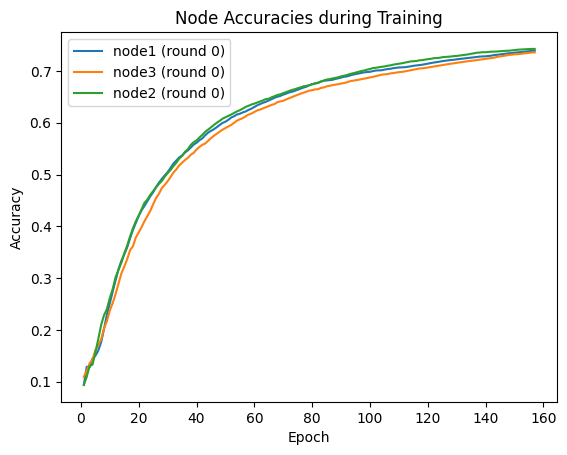

In [29]:
import matplotlib.pyplot as plt

for exp_name, rounds in local_logs.items():
    for round_num, nodes_metrics in rounds.items():
        for node_name, metrics in nodes_metrics.items():
            for metric, values in metrics.items():
                if "acc" in metric.lower():
                    x, y = zip(*values)
                    plt.plot(x, y, label=f"{node_name} (round {round_num})")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Node Accuracies during Training")
plt.show()

# <h2 style="text-align:center; font-size:2em; margin-top:1em;"> 7. 🔧 Configuring your experiments</h2>


# 

You can have a more fine-grained control over the `p2pfl`behavior through the global `Settings` object. This object allows you to adjust timeouts, logging levels, and protocol-specific parameters.

In [ ]:
from p2pfl.settings import Settings

The settings are grouped into categories. 

- **General:**  : System settings like random seed, logging, and global timeouts.
- **Heartbeat:** : Parameters for node health checks and failure detection.
- **Gossip:** : Gossip protocol settings, including message frequency, TTL, and model exchange.
- **SSL:** : SSL/TLS certificate paths and options for secure communication.
- **Training:** : Training-related options such as timeouts, batch size, and Ray pool size.

Let's inspect the default `training` settings.

In [ ]:
training_settings = Settings.training

print("--- Default Training Settings ---")
for setting, value in training_settings.__dict__.items():
    print(f"{setting}: {value}")

Changing a setting is as simple as assigning a new value. For example, let's increase the timeout for how long a node waits to receive models from its peers during aggregation.

In [ ]:
Settings.training.AGGREGATION_TIMEOUT = 120
print(f"New aggregation timeout: {Settings.training.AGGREGATION_TIMEOUT}s")

# <h2 style="text-align:center; font-size:2em; margin-top:1em;"> 8. 🧩 P2PFL Architecture</h2>


<div align="center">
  <img src="../../other/architecture.png" width="900"/>
</div>


The `p2pfl` architecture is centered around the `Node` class and it's focused on being modular.
You can easily swap core components like *aggregators*, *communication protocols* and *compression methods* to design your experiments.

On this section we'll review some of the main components of the library. 

### Node Components


A `Node` in `p2pfl` is an autonomous entity with:

- **Logger**: Records all important events, metrics, and debug info for that node.
- **State**: Manages the current model weights, round number, neighbor list, and checkpoints for recovery.
- **Learning**: Contains both the `Learner` (ML framework logic) and the `Dataset` (local data partition).
    - **Learner**: Abstracts the ML backend. Supported: `PyTorch`, `TensorFlow`, `Flax`.
        - *Example*:  
            ```python
            from p2pfl.ml import KerasModel
            learner = KerasModel(model=my_keras_model)
            ```
    - **Dataset**: Each node holds its own local partition (e.g., a chunk of MNIST).

    - **Aggregator**: Defines how to combine received models or gradients.
- **Communication Protocol**: Handles network messaging between nodes.
- **Commands**: Encapsulates the set of messages/actions that nodes can send/receive (e.g., model update, request metrics).
- **Workflow**: The orchestration logic, specifying the training loop, round handling, and termination criteria.


### Aggregators

The **aggregator** defines how models are combined. We've used `FedAvg` on our previous example, but many others are available on the library for different scenarios:
- **For Non-IID Data**: `FedProx` and `Scaffold` are designed to improve stability and accuracy when data is not evenly distributed.
- **For Security**: `Krum` and `FedMedian` are robust against outlier or malicious model updates.
- **For Efficiency**: `FedAdagrad` and `FedYogi` are adaptive optimizers that can sometimes speed up convergence.


- *You simply pass a different aggregator class when creating your nodes:*
    ```python
    from p2pfl.aggregation import FedMedian
    node = Node(..., aggregator=FedMedian())
    ```


### Communication Protocols

The **protocol** handles the networking, how nodes talk with each other.
- **`MemoryCommunicationProtocol`**: Perfect for single-machine simulations like this notebook.
- **`GrpcCommunicationProtocol`**: A high-performance option for real-world experiments across multiple machines.



### Commands
`p2pfl` uses a set of **structured internal commands** to manage communication between nodes. These commands ensure reliable, extendable, and clear message handling between nodes—not typically interacted with directly, but essential under the hood.


| Category | Command class | Purpose (one-liner) |
|----------|---------------|---------------------|
| **Lifecycle** | `StartLearningCommand` | Kick off the learning workflow |
|              | `StopLearningCommand`  | Gracefully halt all activity |
| **Coordination** | `ModelInitializedCommand` | Signal that the initial model has been gossiped |
|                 | `VoteTrainSetCommand`     | Vote which peers form the training set this round |
|                 | `ModelsAggregatedCommand` | Notify peers when local aggregation finishes |
|                 | `ModelsReadyCommand`      | Announce that the aggregated model is ready |
| **Metrics**     | `MetricsCommand`          | Broadcast evaluation metrics |
| **Weights / Data** | `InitModelCommand`     | Send the very first model parameters |
|                   | `PartialModelCommand`  | Share *partial* (aggregated) weights |
|                   | `FullModelCommand`     | Share a *full* model snapshot |
| **Flow Control** | `PreSendModelCommand`   | Ask permission / avoid redundant transfers |



### 🔄 Workflows

A **Workflow** is the orchestration engine that drives every node through a
repeatable training-communication cycle.  Internally it is implemented as a
*state-machine pipeline* made of **Stage** classes; each stage knows **when**
to run, **what** to do, and **which stage** comes next.

**Default workflow:**

| Order | Stage | What happens |
|-------|-------|--------------|
| 1 | **StartLearningStage** | The node waits until it has gossiped an initial model to all peers, then triggers the workflow. |
| 2 | **VoteTrainSetStage** | Peers vote which subset will train this round (light-weight load balancing). |
| 3a | **TrainStage** <br>(if _in_ the train set) | Local fitting + local aggregation; metrics are computed. |
| 3b | **WaitAggregatedModelsStage** <br>(if _not_ in the train set) | Non-training nodes idle until they hear the final aggregated model for the round. |
| 4 | **GossipModelStage** | The aggregated weights are pushed to every neighbour to keep the swarm in sync. |
| 5 | **RoundFinishedStage** | Book-keeping: increment `round`, clear buffers, call user hooks. If more rounds remain it loops back to **VoteTrainSetStage**; otherwise, **StopLearningStage** (not shown) halts everything. |


<div align="center">
  <img src="../../other/workflow.png" width="1000"/>
</div>


# <h2 style="text-align:center; font-size:2em; margin-top:1em;"> 9. ✔ Conclussions</h2>


Now, after exploring the main features and workflow of the `p2pfl` library, you should now have a solid grasp of the building blocks needed to create and run your own peer-to-peer federated learning experiments.

<div style="margin-top:18px; font-size:1.15em;">
  🚀 <b>Thank you for exploring P2PFL!</b> If you have questions, ideas, or want to contribute, check out the <a href="https://github.com/pguijas/p2pfl" style="color:#248cff; text-decoration:underline;"><b>P2PFL GitHub repository</b></a>.
</div>
